# Titanic - Machine Learning from Disaster

The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

Link to contest : https://www.kaggle.com/c/titanic/overview/description

## 1) Importing the libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import xgboost as xgb

# For training

## 2) Data Preprocessing

* **Data Dictionary**

- survival ---	Survival	0 = No, 1 = Yes
- pclass	 ---   Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
- sex	     ---   Sex	
- Age	     ---   Age in years	
- sibsp    ---  	# of siblings / spouses aboard the Titanic	
- parch    --- 	# of parents / children aboard the Titanic	
- ticket	 ---   Ticket number	
- fare	   ---   Passenger fare	
- cabin    --- 	Cabin number	
- embarked --- 	Port of Embarkation	C = Cherbourg, Q =  Queenstown, S = Southampton

- Variable Notes
* pclass: A proxy for socio-economic status (SES)<br>
1st = Upper<br>
2nd = Middle<br>
3rd = Lower<br>

* age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

* sibsp: The dataset defines family relations in this way...<br>
Sibling = brother, sister, stepbrother, stepsister<br>
Spouse = husband, wife (mistresses and fiancés were ignored)

* parch: The dataset defines family relations in this way...<br>
Parent = mother, father<br>
Child = daughter, son, stepdaughter, stepson<br>
Some children travelled only with a nanny, therefore parch=0 for them.

In [64]:
df = pd.read_csv('drive/My Drive/Pytorch_DataSet/Titanic Data/train.csv')
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [0]:
def title_corr(t):
    newt = t
    if t == 'Mrs' or t == 'Mr' or t == 'Miss':
        return newt
    elif t == 'Capt' or t == 'Col' or t == 'Major' or t == 'Dr' or t == 'Rev':
        newt = 'Crew'
    elif t == 'Jonkheer' or t == 'Sir' or t == 'the Countess' or t == 'Lady' or t == 'Master':
        newt = 'Noble'
    elif t == 'Don':
        newt = 'Mr'
    elif t == 'Dona' or t == 'Ms' or t == 'Mme':
        newt = 'Mrs'
    elif t == 'Mlle':
        newt = 'Miss'
    else: print("Title not included:", t)
    return newt

# Extract the titles from the name and put them in a list, then correct them
# Train data
#df.insert(3,"Titles", "Empty")
titles = list()
for name in df["Name"]:
    titles.append(name.split(',')[1].split('.')[0].strip())
for i in range(len(titles)):
    titles[i] = title_corr(titles[i])
df["Titles"] = titles


In [66]:
df['Total Family'] = df['SibSp'] + df['Parch']
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Titles,Total Family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,0


In [67]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Total Family
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.904602
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,1.613459
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,10.000000


In [68]:
len(df)

891

In [69]:
df.isnull().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             177
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           687
Embarked          2
Titles            0
Total Family      0
dtype: int64

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 54.,  46., 177., 169., 118.,  70.,  45.,  24.,   9.,   2.]),
 array([ 0.42 ,  8.378, 16.336, 24.294, 32.252, 40.21 , 48.168, 56.126,
        64.084, 72.042, 80.   ]),
 <a list of 10 Patch objects>)

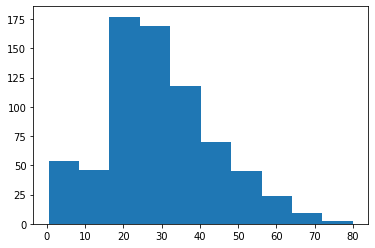

In [70]:
plt.hist(df['Age'])

(array([608., 209.,  28.,  16.,   0.,  18.,   5.,   0.,   0.,   7.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

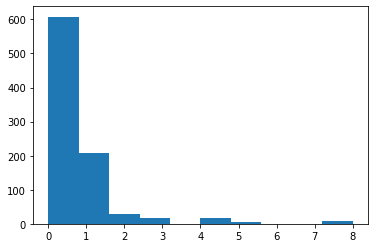

In [71]:
plt.hist(df['SibSp'])

(array([678., 118.,   0.,  80.,   0.,   5.,   4.,   0.,   5.,   1.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

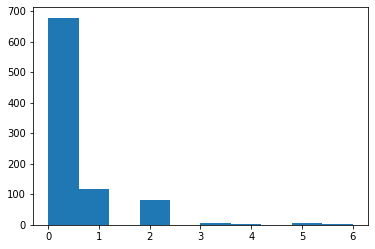

In [72]:
plt.hist(df['Parch'])

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   891 non-null    int64  
 1   Survived      891 non-null    int64  
 2   Pclass        891 non-null    int64  
 3   Name          891 non-null    object 
 4   Sex           891 non-null    object 
 5   Age           714 non-null    float64
 6   SibSp         891 non-null    int64  
 7   Parch         891 non-null    int64  
 8   Ticket        891 non-null    object 
 9   Fare          891 non-null    float64
 10  Cabin         204 non-null    object 
 11  Embarked      889 non-null    object 
 12  Titles        891 non-null    object 
 13  Total Family  891 non-null    int64  
dtypes: float64(2), int64(6), object(6)
memory usage: 97.6+ KB


- Here, we can see that Cabin has got about 80-85% null values.So, it can be removed.
- Moreover, Name and Ticket are not good parameters for training.
- Therefore, these columns can be removed.

In [0]:
#df['Embarked'].fillna(df['Embarked'].mode(),inplace=True)
df = df.drop('Name',axis=1)
df = df.drop('Ticket',axis=1)
df = df.drop('Cabin',axis=1)
df['Age'].fillna(df['Age'].median(),inplace=True)


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   891 non-null    int64  
 1   Survived      891 non-null    int64  
 2   Pclass        891 non-null    int64  
 3   Sex           891 non-null    object 
 4   Age           891 non-null    float64
 5   SibSp         891 non-null    int64  
 6   Parch         891 non-null    int64  
 7   Fare          891 non-null    float64
 8   Embarked      889 non-null    object 
 9   Titles        891 non-null    object 
 10  Total Family  891 non-null    int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 76.7+ KB


In [76]:
df.isnull().sum()

PassengerId     0
Survived        0
Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
Embarked        2
Titles          0
Total Family    0
dtype: int64

In [77]:
df['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [0]:
df['Embarked'].fillna('S',inplace=True)

In [79]:
df['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [80]:
# Converting the Object datatype into Category type

cat_cols = []
for col in df.columns:
  if df[col].dtype == 'O':
    cat_cols.append(col)

print(cat_cols)    

['Sex', 'Embarked', 'Titles']


In [81]:
for col in cat_cols:
  df[col] = df[col].astype('category')

df.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   PassengerId   891 non-null    int64   
 1   Survived      891 non-null    int64   
 2   Pclass        891 non-null    int64   
 3   Sex           891 non-null    category
 4   Age           891 non-null    float64 
 5   SibSp         891 non-null    int64   
 6   Parch         891 non-null    int64   
 7   Fare          891 non-null    float64 
 8   Embarked      891 non-null    category
 9   Titles        891 non-null    category
 10  Total Family  891 non-null    int64   
dtypes: category(3), float64(2), int64(6)
memory usage: 58.8 KB


In [0]:
# Converting the category cols to integers

for col in cat_cols:
  df[col] = df[col].cat.codes.values

In [83]:
cat_data = df[['Pclass','Sex','Embarked','Titles']].values
cat_data

array([[3, 1, 2, 2],
       [1, 0, 0, 3],
       [3, 0, 2, 1],
       ...,
       [3, 0, 2, 1],
       [1, 1, 0, 2],
       [3, 1, 1, 2]])

In [84]:
print(max(df['Pclass']), max(df['Sex']), max(df['Embarked']),max(df['Titles']))
print(min(df['Pclass']), min(df['Sex']), min(df['Embarked']),min(df['Titles']))

3 1 2 4
1 0 0 0


In [85]:
from sklearn.preprocessing import OneHotEncoder 
  
onehotencoder = OneHotEncoder() 
cat_data = onehotencoder.fit_transform(cat_data).toarray()
print(cat_data.shape, type(cat_data))
print(cat_data)


(891, 13) <class 'numpy.ndarray'>
[[0. 0. 1. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 1. 0. 0.]]


In [86]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Titles,Total Family
0,1,0,3,1,22.0,1,0,7.2500,2,2,1
1,2,1,1,0,38.0,1,0,71.2833,0,3,1
2,3,1,3,0,26.0,0,0,7.9250,2,1,0
3,4,1,1,0,35.0,1,0,53.1000,2,3,1
4,5,0,3,1,35.0,0,0,8.0500,2,2,0


In [87]:
df.isnull().sum()

PassengerId     0
Survived        0
Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
Embarked        0
Titles          0
Total Family    0
dtype: int64

In [0]:
# Splitting the data into features and labels

X = df[['Age','Fare','Total Family']].values
y = df['Survived'].values

In [89]:
X.shape, X[:10], type(X)

((891, 3), array([[22.    ,  7.25  ,  1.    ],
        [38.    , 71.2833,  1.    ],
        [26.    ,  7.925 ,  0.    ],
        [35.    , 53.1   ,  1.    ],
        [35.    ,  8.05  ,  0.    ],
        [28.    ,  8.4583,  0.    ],
        [54.    , 51.8625,  0.    ],
        [ 2.    , 21.075 ,  4.    ],
        [27.    , 11.1333,  2.    ],
        [14.    , 30.0708,  1.    ]]), numpy.ndarray)

In [90]:
X = np.concatenate((X,cat_data),axis=1)
X

array([[22.    ,  7.25  ,  1.    , ...,  1.    ,  0.    ,  0.    ],
       [38.    , 71.2833,  1.    , ...,  0.    ,  1.    ,  0.    ],
       [26.    ,  7.925 ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       ...,
       [28.    , 23.45  ,  3.    , ...,  0.    ,  0.    ,  0.    ],
       [26.    , 30.    ,  0.    , ...,  1.    ,  0.    ,  0.    ],
       [32.    ,  7.75  ,  0.    , ...,  1.    ,  0.    ,  0.    ]])

In [91]:
X.shape, type(X)

((891, 16), numpy.ndarray)

In [92]:
y.shape , y[:10]

((891,), array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1]))

In [93]:
input_data = xgb.DMatrix(data=X,label=y)
input_data

## 3) Splitting the data into train and test set

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.03,random_state=0)

In [0]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## 4) Building the XGBoost Model

In [0]:
xg_clf = xgb.XGBClassifier(objective ='binary:logistic', 
                          colsample_bytree = 0.4, 
                          learning_rate = 0.01,
                          max_depth = 6,  
                          n_estimators = 26,
                          random_state=10)

In [97]:
xg_clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=26, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## 6) Predicting the results

In [0]:
y_preds = xg_clf.predict(X_test)

In [99]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_preds,y_test)
print(cm)

[[13  2]
 [ 1 11]]


In [100]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_preds,y_test))

0.8888888888888888


In [0]:
# K-Fold Cross Validation

params = {"objective":"binary:logistic",
          'colsample_bytree': 0.3,
          'learning_rate': 0.01,
          'max_depth': 15, 
          'alpha': 10}

cv_results = xgb.cv(dtrain=input_data, 
                    params=params, 
                    nfold=5,
                    num_boost_round=1000,
                    early_stopping_rounds=10, 
                    as_pandas=True, 
                    seed=123)

In [102]:
cv_results.head()

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.299666,0.012791,0.299711,0.051186
1,0.214368,0.013300,0.223313,0.021354
2,0.203422,0.019365,0.216622,0.015466
3,0.200621,0.019987,0.213238,0.028602
4,0.197533,0.019326,0.208763,0.028349


In [103]:
print((cv_results["test-error-mean"]).tail(1))

8    0.19081
Name: test-error-mean, dtype: float64


## 7) Important Features

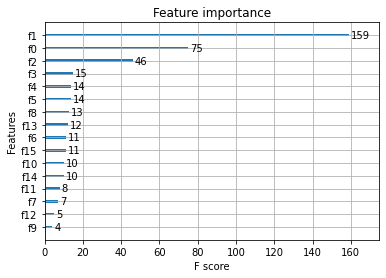

In [104]:
xgb.plot_importance(xg_clf)
#plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

# For Testing

## 2) Data Preprocessing

In [105]:
df = pd.read_csv('drive/My Drive/Pytorch_DataSet/Titanic Data/test.csv')
df.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


In [0]:
def title_corr(t):
    newt = t
    if t == 'Mrs' or t == 'Mr' or t == 'Miss':
        return newt
    elif t == 'Capt' or t == 'Col' or t == 'Major' or t == 'Dr' or t == 'Rev':
        newt = 'Crew'
    elif t == 'Jonkheer' or t == 'Sir' or t == 'the Countess' or t == 'Lady' or t == 'Master':
        newt = 'Noble'
    elif t == 'Don':
        newt = 'Mr'
    elif t == 'Dona' or t == 'Ms' or t == 'Mme':
        newt = 'Mrs'
    elif t == 'Mlle':
        newt = 'Miss'
    else: print("Title not included:", t)
    return newt

titles = list()
for name in df["Name"]:
    titles.append(name.split(',')[1].split('.')[0].strip())
for i in range(len(titles)):
    titles[i] = title_corr(titles[i])
df["Titles"] = titles

In [107]:
df['Total Family'] = df['SibSp'] + df['Parch']
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Titles,Total Family
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs,2


In [108]:
df['Titles'].unique()

array(['Mr', 'Mrs', 'Miss', 'Noble', 'Crew'], dtype=object)

In [109]:
len(df)

418

In [110]:
df.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age              86
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin           327
Embarked          0
Titles            0
Total Family      0
dtype: int64

In [0]:
df['Fare'].fillna(df['Fare'].median(),inplace=True)
df = df.drop('Name',axis=1)
df = df.drop('Ticket',axis=1)
df = df.drop('Cabin',axis=1)
df['Age'].fillna(df['Age'].median(),inplace=True)

In [0]:
cat_cols = ['Sex','Embarked','Titles']

In [0]:
# Converting the category cols to integers
for col in cat_cols:
  df[col] = df[col].astype('category')

for col in cat_cols:
  df[col] = df[col].cat.codes.values

In [114]:
cat_data = df[['Pclass','Sex','Embarked','Titles']].values
cat_data

array([[3, 1, 1, 2],
       [3, 0, 2, 3],
       [2, 1, 1, 2],
       ...,
       [3, 1, 2, 2],
       [3, 1, 2, 2],
       [3, 1, 0, 4]])

In [115]:
from sklearn.preprocessing import OneHotEncoder 
  
onehotencoder = OneHotEncoder() 
cat_data = onehotencoder.fit_transform(cat_data).toarray()
print(cat_data.shape, type(cat_data))
print(cat_data)

(418, 13) <class 'numpy.ndarray'>
[[0. 0. 1. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [0. 1. 0. ... 1. 0. 0.]
 ...
 [0. 0. 1. ... 1. 0. 0.]
 [0. 0. 1. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 1.]]


In [116]:
print(max(df['Pclass']), max(df['Sex']), max(df['Embarked']),max(df['Titles']))
print(min(df['Pclass']), min(df['Sex']), min(df['Embarked']),min(df['Titles']))

3 1 2 4
1 0 0 0


In [0]:
# Splitting the data into features and labels

X_test = df[['Age','Fare','Total Family']].values

In [118]:
X_test = np.concatenate((X_test,cat_data),axis=1)
X_test

array([[34.5   ,  7.8292,  0.    , ...,  1.    ,  0.    ,  0.    ],
       [47.    ,  7.    ,  1.    , ...,  0.    ,  1.    ,  0.    ],
       [62.    ,  9.6875,  0.    , ...,  1.    ,  0.    ,  0.    ],
       ...,
       [38.5   ,  7.25  ,  0.    , ...,  1.    ,  0.    ,  0.    ],
       [27.    ,  8.05  ,  0.    , ...,  1.    ,  0.    ,  0.    ],
       [27.    , 22.3583,  2.    , ...,  0.    ,  0.    ,  1.    ]])

In [0]:
X_test = sc.transform(X_test)

In [120]:
X_test.shape

(418, 16)

## 3) Predicting the results

In [0]:
y_preds = xg_clf.predict(X_test)

In [122]:
y_preds

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

## 4) Saving the results into a csv file

In [123]:
submission = pd.DataFrame({'PassengerId':df['PassengerId'],'Survived':y_preds})
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [0]:
submission.to_csv('kaggle_titanic.csv',index=False)